# Installations

In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 618.7 kB/s eta 0:00:00 0:00:01
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-pcczpk78
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-pcczpk78
  Resolved https://github.com/openai/CLIP.git to commit d50d76daa670286dd6cacf3bcd80b5e4823fc8e1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=1b8a246aa48f3a2d2a258844bdebf2cd89107505b6b2b52348991bc27424957d
  Stored in directory: /tmp/pip-ephem-wheel-cache-j0m1b8wv/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


# Imports

In [2]:
from PIL import Image
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import clip

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchinfo import summary
from tqdm import tqdm
from torch.nn.functional import normalize
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

import math
import cv2

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# CLIP model

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [5]:
EMB_SIZE = 64
OUTPUT_CLASSES = 2142  #1424   #1034 #1902 #1346
BATCH_SIZE = 256
EPOCH = 5
WORKERS = 2
VAL_LOSS = []
TRAIN_LOSS = []
MARGIN = 0.5 # TRY # 0 for faster convergence, larger may be beneficial
# init_lr = 3e-4

In [6]:
# model, preprocess = clip.load("ViT-L/14", device=device, jit=True) 

In [7]:
clip_code = "ViT-L/14@336px"
model, preprocess = clip.load("ViT-L/14@336px", jit=True, device=device)

100%|███████████████████████████████████████| 891M/891M [00:15<00:00, 58.4MiB/s]


# Laion5B

In [8]:
# import os
# import pandas as pd

# root_path = "/kaggle/input/ab-balanced-laion5b/dataset"

# for root, dirnames, filenames in os.walk(root_path):
#     dir_names = dirnames
#     break

In [9]:
# from glob import glob

# img_path = []
# caption = []
# for dir in dir_names:
#     for f_name in glob(os.path.join(root_path, dir, '*.json')):
#         df_json = pd.read_json(os.path.join(root_path, dir,f_name), typ='series')
#         if df_json['status'] == "success":
#             img_path.append(os.path.join(root_path, dir,f_name.split(".")[0] + '.jpg'))
#             caption.append(df_json['caption'])
        
# df_laion5b = pd.DataFrame({'img_path': img_path, 'class': caption})

In [10]:
# len(df_laion5b)

In [11]:
# df_laion5b.head()

In [12]:
# df_laion5b['img_path'][0]

In [13]:
# df_laion5b['class'].value_counts()

# WIT

In [14]:
# import os
# import pandas as pd
# from glob import glob

In [15]:
# root_path = "../input/ab-wit-ds"

# for root, dirnames, filenames in os.walk(root_path):
#     dir_names = dirnames
#     break

In [16]:
# img_path = []
# caption = []
# for dir in dir_names:
#     for f_name in glob(os.path.join(root_path, dir, '00000', '*.json')):
#         df_json = pd.read_json(f_name, typ='series') #os.path.join(root_path, dir, '00000', f_name)
#         if df_json['status'] == "success":
#             img_path.append(f_name.strip().split(".")[2] + '.jpg')
#             caption.append(df_json['caption'])
        
# df_wit_1 = pd.DataFrame({'img_path': img_path, 'class': caption})

In [17]:
# root_path = "../input/ab-wit-ds-2"

# for root, dirnames, filenames in os.walk(root_path):
#     dir_names = dirnames
#     break
    
# img_path = []
# caption = []
# for dir in dir_names:
#     for f_name in glob(os.path.join(root_path, dir, '00000', '*.json')):
#         df_json = pd.read_json(f_name, typ='series') #os.path.join(root_path, dir, '00000', f_name)
#         if df_json['status'] == "success":
#             img_path.append(f_name.strip().split(".")[2] + '.jpg')
#             caption.append(df_json['caption'])
        
# df_wit_2 = pd.DataFrame({'img_path': img_path, 'class': caption})    

In [18]:
# root_path = "../input/ab-wit-ds-3"

# for root, dirnames, filenames in os.walk(root_path):
#     dir_names = dirnames
#     break
    
# img_path = []
# caption = []
# for dir in dir_names:
#     for f_name in glob(os.path.join(root_path, dir, '00000', '*.json')):
#         df_json = pd.read_json(f_name, typ='series') #os.path.join(root_path, dir, '00000', f_name)
#         if df_json['status'] == "success":
#             img_path.append(f_name.strip().split(".")[2] + '.jpg')
#             caption.append(df_json['caption'])
        
# df_wit_3 = pd.DataFrame({'img_path': img_path, 'class': caption})    

In [19]:
# root_path = "../input/ab-wit-ds-4"

# for root, dirnames, filenames in os.walk(root_path):
#     dir_names = dirnames
#     break
    
# img_path = []
# caption = []
# for dir in dir_names:
#     for f_name in glob(os.path.join(root_path, dir, '00000', '*.json')):
#         df_json = pd.read_json(f_name, typ='series') #os.path.join(root_path, dir, '00000', f_name)
#         if df_json['status'] == "success":
#             img_path.append(f_name.strip().split(".")[2] + '.jpg')
#             caption.append(df_json['caption'])
        
# df_wit_4 = pd.DataFrame({'img_path': img_path, 'class': caption})    

In [20]:
# root_path = "../input/ab-wit-ds-5"

# for root, dirnames, filenames in os.walk(root_path):
#     dir_names = dirnames
#     break
    
# img_path = []
# caption = []
# for dir in dir_names:
#     for f_name in glob(os.path.join(root_path, dir, '00000', '*.json')):
#         df_json = pd.read_json(f_name, typ='series') #os.path.join(root_path, dir, '00000', f_name)
#         if df_json['status'] == "success":
#             img_path.append(f_name.strip().split(".")[2] + '.jpg')
#             caption.append(df_json['caption'])
        
# df_wit_5 = pd.DataFrame({'img_path': img_path, 'class': caption})    

In [21]:
# df_wit = pd.concat([
#     df_wit_1,
#     df_wit_2,
#     df_wit_3,
#     df_wit_4,
#     df_wit_5
# ], axis=0)

# df_wit.head()

In [22]:
# df_wit = df_wit_1.copy()

In [23]:
# df_wit['class'] = df_wit['class'].str.replace("List of ", "")
# df_wit.head()

In [24]:
# df_wit['class'].nunique()

In [25]:
# df_wit['class'].value_counts()

In [26]:
# counts = df_wit['class'].value_counts()

# df_wit = df_wit[~df_wit['class'].isin(counts[counts < 2].index)]
# df_wit.head()

In [27]:
# df_wit['class'].value_counts()

In [28]:
# df_wit['class'].nunique()

In [29]:
# df_wit['img_path'] = df_wit['img_path'].str.replace("/input", "/kaggle/input")
# df_wit.head()

In [30]:
# exclude = []
# for idx, row in df_wit.iterrows():
#     try:
#         Image.open(row["img_path"])
#     except:
#         exclude.append(row["img_path"])

In [31]:
# exclude

# imagenet mini

In [32]:
# import glob

In [33]:
# # n_imagenetmini = 5000
# INPUT_DIR = '/kaggle/input'
# imagenet_cls_map = {'n02119789': 'kit fox, Vulpes macrotis', 'n02100735': 'English setter', 'n02096294': 'Australian terrier', 'n02066245': 'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus', 'n02509815': 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens', 'n02124075': 'Egyptian cat', 'n02417914': 'ibex, Capra ibex', 'n02123394': 'Persian cat', 'n02125311': 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor', 'n02423022': 'gazelle', 'n02346627': 'porcupine, hedgehog', 'n02077923': 'sea lion', 'n02447366': 'badger', 'n02109047': 'Great Dane', 'n02092002': 'Scottish deerhound, deerhound', 'n02071294': 'killer whale, killer, orca, grampus, sea wolf, Orcinus orca', 'n02442845': 'mink', 'n02504458': 'African elephant, Loxodonta africana', 'n02114712': 'red wolf, maned wolf, Canis rufus, Canis niger', 'n02128925': 'jaguar, panther, Panthera onca, Felis onca', 'n02117135': 'hyena, hyaena', 'n02493509': 'titi, titi monkey', 'n02457408': 'three-toed sloth, ai, Bradypus tridactylus', 'n02389026': 'sorrel', 'n02443484': 'black-footed ferret, ferret, Mustela nigripes', 'n02110341': 'dalmatian, coach dog, carriage dog', 'n02093256': 'Staffordshire bullterrier, Staffordshire bull terrier', 'n02106382': 'Bouvier des Flandres, Bouviers des Flandres', 'n02441942': 'weasel', 'n02113712': 'miniature poodle', 'n02415577': 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis', 'n02356798': 'fox squirrel, eastern fox squirrel, Sciurus niger', 'n02488702': 'colobus, colobus monkey', 'n02123159': 'tiger cat', 'n02422699': 'impala, Aepyceros melampus', 'n02114855': 'coyote, prairie wolf, brush wolf, Canis latrans', 'n02094433': 'Yorkshire terrier', 'n02111277': 'Newfoundland, Newfoundland dog', 'n02119022': 'red fox, Vulpes vulpes', 'n02422106': 'hartebeest', 'n02120505': 'grey fox, gray fox, Urocyon cinereoargenteus', 'n02086079': 'Pekinese, Pekingese, Peke', 'n02484975': 'guenon, guenon monkey', 'n02137549': 'mongoose', 'n02500267': 'indri, indris, Indri indri, Indri brevicaudatus', 'n02129604': 'tiger, Panthera tigris', 'n02396427': 'wild boar, boar, Sus scrofa', 'n02391049': 'zebra', 'n02412080': 'ram, tup', 'n02480495': 'orangutan, orang, orangutang, Pongo pygmaeus', 'n02110806': 'basenji', 'n02128385': 'leopard, Panthera pardus', 'n02100583': 'vizsla, Hungarian pointer', 'n02494079': 'squirrel monkey, Saimiri sciureus', 'n02123597': 'Siamese cat, Siamese', 'n02481823': 'chimpanzee, chimp, Pan troglodytes', 'n02105505': 'komondor', 'n02489166': 'proboscis monkey, Nasalis larvatus', 'n02364673': 'guinea pig, Cavia cobaya', 'n02114548': 'white wolf, Arctic wolf, Canis lupus tundrarum', 'n02134084': 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus', 'n02480855': 'gorilla, Gorilla gorilla', 'n02403003': 'ox', 'n02108551': 'Tibetan mastiff', 'n02493793': 'spider monkey, Ateles geoffroyi', 'n02107142': 'Doberman, Doberman pinscher', 'n02397096': 'warthog', 'n02437312': 'Arabian camel, dromedary, Camelus dromedarius', 'n02483708': 'siamang, Hylobates syndactylus, Symphalangus syndactylus', 'n02099601': 'golden retriever', 'n02106166': 'Border collie', 'n02326432': 'hare', 'n02108089': 'boxer', 'n02486261': 'patas, hussar monkey, Erythrocebus patas', 'n02486410': 'baboon', 'n02487347': 'macaque', 'n02492035': 'capuchin, ringtail, Cebus capucinus', 'n02099267': 'flat-coated retriever', 'n02395406': 'hog, pig, grunter, squealer, Sus scrofa', 'n02109961': 'Eskimo dog, husky', 'n02101388': 'Brittany spaniel', 'n03187595': 'dial telephone, dial phone', 'n03733281': 'maze, labyrinth', 'n02101006': 'Gordon setter', 'n02115641': 'dingo, warrigal, warragal, Canis dingo', 'n02342885': 'hamster', 'n02120079': 'Arctic fox, white fox, Alopex lagopus', 'n02408429': 'water buffalo, water ox, Asiatic buffalo, Bubalus bubalis', 'n02133161': 'American black bear, black bear, Ursus americanus, Euarctos americanus', 'n02328150': 'Angora, Angora rabbit', 'n02410509': 'bison', 'n02492660': 'howler monkey, howler', 'n02398521': 'hippopotamus, hippo, river horse, Hippopotamus amphibius', 'n02510455': 'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca', 'n02123045': 'tabby, tabby cat', 'n02490219': 'marmoset', 'n02109525': 'Saint Bernard, St Bernard', 'n02454379': 'armadillo', 'n02090379': 'redbone', 'n02443114': 'polecat, fitch, foulmart, foumart, Mustela putorius', 'n02361337': 'marmot', 'n02483362': 'gibbon, Hylobates lar', 'n02437616': 'llama', 'n02325366': 'wood rabbit, cottontail, cottontail rabbit', 'n02129165': 'lion, king of beasts, Panthera leo', 'n02100877': 'Irish setter, red setter', 'n02074367': 'dugong, Dugong dugon', 'n02504013': 'Indian elephant, Elephas maximus', 'n02363005': 'beaver', 'n02497673': 'Madagascar cat, ring-tailed lemur, Lemur catta', 'n02087394': 'Rhodesian ridgeback', 'n02127052': 'lynx, catamount', 'n02116738': 'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus', 'n02488291': 'langur', 'n02114367': 'timber wolf, grey wolf, gray wolf, Canis lupus', 'n02130308': 'cheetah, chetah, Acinonyx jubatus', 'n02134418': 'sloth bear, Melursus ursinus, Ursus ursinus', 'n02106662': 'German shepherd, German shepherd dog, German police dog, alsatian', 'n02444819': 'otter', 'n01882714': 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus', 'n01871265': 'tusker', 'n01872401': 'echidna, spiny anteater, anteater', 'n01877812': 'wallaby, brush kangaroo', 'n01873310': 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus', 'n01883070': 'wombat', 'n04086273': 'revolver, six-gun, six-shooter', 'n04507155': 'umbrella', 'n04147183': 'schooner', 'n04254680': 'soccer ball', 'n02672831': 'accordion, piano accordion, squeeze box', 'n02219486': 'ant, emmet, pismire', 'n02317335': 'starfish, sea star', 'n01968897': 'chambered nautilus, pearly nautilus, nautilus', 'n03452741': 'grand piano, grand', 'n03642806': 'laptop, laptop computer', 'n07745940': 'strawberry', 'n02690373': 'airliner', 'n04552348': 'warplane, military plane', 'n02692877': 'airship, dirigible', 'n02782093': 'balloon', 'n04266014': 'space shuttle', 'n03344393': 'fireboat', 'n03447447': 'gondola', 'n04273569': 'speedboat', 'n03662601': 'lifeboat', 'n02951358': 'canoe', 'n04612504': 'yawl', 'n02981792': 'catamaran', 'n04483307': 'trimaran', 'n03095699': 'container ship, containership, container vessel', 'n03673027': 'liner, ocean liner', 'n03947888': 'pirate, pirate ship', 'n02687172': 'aircraft carrier, carrier, flattop, attack aircraft carrier', 'n04347754': 'submarine, pigboat, sub, U-boat', 'n04606251': 'wreck', 'n03478589': 'half track', 'n04389033': 'tank, army tank, armored combat vehicle, armoured combat vehicle', 'n03773504': 'missile', 'n02860847': 'bobsled, bobsleigh, bob', 'n03218198': 'dogsled, dog sled, dog sleigh', 'n02835271': 'bicycle-built-for-two, tandem bicycle, tandem', 'n03792782': 'mountain bike, all-terrain bike, off-roader', 'n03393912': 'freight car', 'n03895866': 'passenger car, coach, carriage', 'n02797295': 'barrow, garden cart, lawn cart, wheelbarrow', 'n04204347': 'shopping cart', 'n03791053': 'motor scooter, scooter', 'n03384352': 'forklift', 'n03272562': 'electric locomotive', 'n04310018': 'steam locomotive', 'n02704792': 'amphibian, amphibious vehicle', 'n02701002': 'ambulance', 'n02814533': 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon', 'n02930766': 'cab, hack, taxi, taxicab', 'n03100240': 'convertible', 'n03594945': 'jeep, landrover', 'n03670208': 'limousine, limo', 'n03770679': 'minivan', 'n03777568': 'Model T', 'n04037443': 'racer, race car, racing car', 'n04285008': 'sports car, sport car', 'n03444034': 'go-kart', 'n03445924': 'golfcart, golf cart', 'n03785016': 'moped', 'n04252225': 'snowplow, snowplough', 'n03345487': 'fire engine, fire truck', 'n03417042': 'garbage truck, dustcart', 'n03930630': 'pickup, pickup truck', 'n04461696': 'tow truck, tow car, wrecker', 'n04467665': 'trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi', 'n03796401': 'moving van', 'n03977966': 'police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria', 'n04065272': 'recreational vehicle, RV, R.V.', 'n04335435': 'streetcar, tram, tramcar, trolley, trolley car', 'n04252077': 'snowmobile', 'n04465501': 'tractor', 'n03776460': 'mobile home, manufactured home', 'n04482393': 'tricycle, trike, velocipede', 'n04509417': 'unicycle, monocycle', 'n03538406': 'horse cart, horse-cart', 'n03788365': 'mosquito net', 'n03868242': 'oxcart', 'n02804414': 'bassinet', 'n03125729': 'cradle', 'n03131574': 'crib, cot', 'n03388549': 'four-poster', 'n02870880': 'bookcase', 'n03018349': 'china cabinet, china closet', 'n03742115': 'medicine chest, medicine cabinet', 'n03016953': 'chiffonier, commode', 'n04380533': 'table lamp', 'n03337140': 'file, file cabinet, filing cabinet', 'n03902125': 'pay-phone, pay-station', 'n03891251': 'park bench', 'n02791124': 'barber chair', 'n04429376': 'throne', 'n03376595': 'folding chair', 'n04099969': 'rocking chair, rocker', 'n04344873': 'studio couch, day bed', 'n04447861': 'toilet seat', 'n03179701': 'desk', 'n03982430': 'pool table, billiard table, snooker table', 'n03201208': 'dining table, board', 'n03290653': 'entertainment center', 'n04550184': 'wardrobe, closet, press', 'n07742313': 'Granny Smith', 'n07747607': 'orange', 'n07749582': 'lemon', 'n07753113': 'fig', 'n07753275': 'pineapple, ananas', 'n07753592': 'banana', 'n07754684': 'jackfruit, jak, jack', 'n07760859': 'custard apple', 'n07768694': 'pomegranate', 'n12267677': 'acorn', 'n12620546': 'hip, rose hip, rosehip', 'n13133613': 'ear, spike, capitulum', 'n11879895': 'rapeseed', 'n12144580': 'corn', 'n12768682': 'buckeye, horse chestnut, conker', 'n03854065': 'organ, pipe organ', 'n04515003': 'upright, upright piano', 'n03017168': 'chime, bell, gong', 'n03249569': 'drum, membranophone, tympan', 'n03447721': 'gong, tam-tam', 'n03720891': 'maraca', 'n03721384': 'marimba, xylophone', 'n04311174': 'steel drum', 'n02787622': 'banjo', 'n02992211': 'cello, violoncello', 'n03637318': 'lampshade, lamp shade', 'n03495258': 'harp', 'n02676566': 'acoustic guitar', 'n03272010': 'electric guitar', 'n03110669': 'cornet, horn, trumpet, trump', 'n03394916': 'French horn, horn', 'n04487394': 'trombone', 'n03494278': 'harmonica, mouth organ, harp, mouth harp', 'n03840681': 'ocarina, sweet potato', 'n03884397': 'panpipe, pandean pipe, syrinx', 'n02804610': 'bassoon', 'n04141076': 'sax, saxophone', 'n03372029': 'flute, transverse flute', 'n11939491': 'daisy', 'n12057211': "yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum", 'n09246464': 'cliff, drop, drop-off', 'n09468604': 'valley, vale', 'n09193705': 'alp', 'n09472597': 'volcano', 'n09399592': 'promontory, headland, head, foreland', 'n09421951': 'sandbar, sand bar', 'n09256479': 'coral reef', 'n09332890': 'lakeside, lakeshore', 'n09428293': 'seashore, coast, seacoast, sea-coast', 'n09288635': 'geyser', 'n03498962': 'hatchet', 'n03041632': 'cleaver, meat cleaver, chopper', 'n03658185': 'letter opener, paper knife, paperknife', 'n03954731': "plane, carpenter's plane, woodworking plane", 'n03995372': 'power drill', 'n03649909': 'lawn mower, mower', 'n03481172': 'hammer', 'n03109150': 'corkscrew, bottle screw', 'n02951585': 'can opener, tin opener', 'n03970156': "plunger, plumber's helper", 'n04154565': 'screwdriver', 'n04208210': 'shovel', 'n03967562': 'plow, plough', 'n03000684': 'chain saw, chainsaw', 'n01514668': 'cock', 'n01514859': 'hen', 'n01518878': 'ostrich, Struthio camelus', 'n01530575': 'brambling, Fringilla montifringilla', 'n01531178': 'goldfinch, Carduelis carduelis', 'n01532829': 'house finch, linnet, Carpodacus mexicanus', 'n01534433': 'junco, snowbird', 'n01537544': 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 'n01558993': 'robin, American robin, Turdus migratorius', 'n01560419': 'bulbul', 'n01580077': 'jay', 'n01582220': 'magpie', 'n01592084': 'chickadee', 'n01601694': 'water ouzel, dipper', 'n01608432': 'kite', 'n01614925': 'bald eagle, American eagle, Haliaeetus leucocephalus', 'n01616318': 'vulture', 'n01622779': 'great grey owl, great gray owl, Strix nebulosa', 'n01795545': 'black grouse', 'n01796340': 'ptarmigan', 'n01797886': 'ruffed grouse, partridge, Bonasa umbellus', 'n01798484': 'prairie chicken, prairie grouse, prairie fowl', 'n01806143': 'peacock', 'n01806567': 'quail', 'n01807496': 'partridge', 'n01817953': 'African grey, African gray, Psittacus erithacus', 'n01818515': 'macaw', 'n01819313': 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita', 'n01820546': 'lorikeet', 'n01824575': 'coucal', 'n01828970': 'bee eater', 'n01829413': 'hornbill', 'n01833805': 'hummingbird', 'n01843065': 'jacamar', 'n01843383': 'toucan', 'n01847000': 'drake', 'n01855032': 'red-breasted merganser, Mergus serrator', 'n01855672': 'goose', 'n01860187': 'black swan, Cygnus atratus', 'n02002556': 'white stork, Ciconia ciconia', 'n02002724': 'black stork, Ciconia nigra', 'n02006656': 'spoonbill', 'n02007558': 'flamingo', 'n02009912': 'American egret, great white heron, Egretta albus', 'n02009229': 'little blue heron, Egretta caerulea', 'n02011460': 'bittern', 'n02012849': 'crane', 'n02013706': 'limpkin, Aramus pictus', 'n02018207': 'American coot, marsh hen, mud hen, water hen, Fulica americana', 'n02018795': 'bustard', 'n02025239': 'ruddy turnstone, Arenaria interpres', 'n02027492': 'red-backed sandpiper, dunlin, Erolia alpina', 'n02028035': 'redshank, Tringa totanus', 'n02033041': 'dowitcher', 'n02037110': 'oystercatcher, oyster catcher', 'n02017213': 'European gallinule, Porphyrio porphyrio', 'n02051845': 'pelican', 'n02056570': 'king penguin, Aptenodytes patagonica', 'n02058221': 'albatross, mollymawk', 'n01484850': 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'n01491361': 'tiger shark, Galeocerdo cuvieri', 'n01494475': 'hammerhead, hammerhead shark', 'n01496331': 'electric ray, crampfish, numbfish, torpedo', 'n01498041': 'stingray', 'n02514041': 'barracouta, snoek', 'n02536864': 'coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch', 'n01440764': 'tench, Tinca tinca', 'n01443537': 'goldfish, Carassius auratus', 'n02526121': 'eel', 'n02606052': 'rock beauty, Holocanthus tricolor', 'n02607072': 'anemone fish', 'n02643566': 'lionfish', 'n02655020': 'puffer, pufferfish, blowfish, globefish', 'n02640242': 'sturgeon', 'n02641379': 'gar, garfish, garpike, billfish, Lepisosteus osseus', 'n01664065': 'loggerhead, loggerhead turtle, Caretta caretta', 'n01667114': 'mud turtle', 'n01667778': 'terrapin', 'n01669191': 'box turtle, box tortoise', 'n01675722': 'banded gecko', 'n01677366': 'common iguana, iguana, Iguana iguana', 'n01682714': 'American chameleon, anole, Anolis carolinensis', 'n01685808': 'whiptail, whiptail lizard', 'n01687978': 'agama', 'n01688243': 'frilled lizard, Chlamydosaurus kingi', 'n01689811': 'alligator lizard', 'n01692333': 'Gila monster, Heloderma suspectum', 'n01693334': 'green lizard, Lacerta viridis', 'n01694178': 'African chameleon, Chamaeleo chamaeleon', 'n01695060': 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis', 'n01704323': 'triceratops', 'n01697457': 'African crocodile, Nile crocodile, Crocodylus niloticus', 'n01698640': 'American alligator, Alligator mississipiensis', 'n01728572': 'thunder snake, worm snake, Carphophis amoenus', 'n01728920': 'ringneck snake, ring-necked snake, ring snake', 'n01729322': 'hognose snake, puff adder, sand viper', 'n01729977': 'green snake, grass snake', 'n01734418': 'king snake, kingsnake', 'n01735189': 'garter snake, grass snake', 'n01737021': 'water snake', 'n01739381': 'vine snake', 'n01740131': 'night snake, Hypsiglena torquata', 'n01742172': 'boa constrictor, Constrictor constrictor', 'n01744401': 'rock python, rock snake, Python sebae', 'n01748264': 'Indian cobra, Naja naja', 'n01749939': 'green mamba', 'n01751748': 'sea snake', 'n01753488': 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus', 'n04326547': 'stone wall', 'n01756291': 'sidewinder, horned rattlesnake, Crotalus cerastes', 'n01629819': 'European fire salamander, Salamandra salamandra', 'n01630670': 'common newt, Triturus vulgaris', 'n01631663': 'eft', 'n01632458': 'spotted salamander, Ambystoma maculatum', 'n01632777': 'axolotl, mud puppy, Ambystoma mexicanum', 'n01641577': 'bullfrog, Rana catesbeiana', 'n01644373': 'tree frog, tree-frog', 'n01644900': 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui', 'n04579432': 'whistle', 'n04592741': 'wing', 'n03876231': 'paintbrush', 'n03868863': 'oxygen mask', 'n04251144': 'snorkel', 'n03691459': 'loudspeaker, speaker, speaker unit, loudspeaker system, speaker system', 'n03759954': 'microphone, mike', 'n04152593': 'screen, CRT screen', 'n03793489': 'mouse, computer mouse', 'n03271574': 'electric fan, blower', 'n03843555': 'oil filter', 'n04332243': 'strainer', 'n04265275': 'space heater', 'n04330267': 'stove', 'n03467068': 'guillotine', 'n02794156': 'barometer', 'n04118776': 'rule, ruler', 'n03841143': 'odometer, hodometer, mileometer, milometer', 'n04141975': 'scale, weighing machine', 'n02708093': 'analog clock', 'n03196217': 'digital clock', 'n04548280': 'wall clock', 'n03544143': 'hourglass', 'n04355338': 'sundial', 'n03891332': 'parking meter', 'n04328186': 'stopwatch, stop watch', 'n03197337': 'digital watch', 'n04317175': 'stethoscope', 'n04376876': 'syringe', 'n03706229': 'magnetic compass', 'n02841315': 'binoculars, field glasses, opera glasses', 'n04009552': 'projector', 'n04356056': 'sunglasses, dark glasses, shades', 'n03692522': "loupe, jeweler's loupe", 'n04044716': 'radio telescope, radio reflector', 'n02879718': 'bow', 'n02950826': 'cannon', 'n02749479': 'assault rifle, assault gun', 'n04090263': 'rifle', 'n04008634': 'projectile, missile', 'n03085013': 'computer keyboard, keypad', 'n04505470': 'typewriter keyboard', 'n03126707': 'crane', 'n03666591': 'lighter, light, igniter, ignitor', 'n02666196': 'abacus', 'n02977058': 'cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM', 'n04238763': 'slide rule, slipstick', 'n03180011': 'desktop computer', 'n03485407': 'hand-held computer, hand-held microcomputer', 'n03832673': 'notebook, notebook computer', 'n03874599': 'padlock', 'n03496892': 'harvester, reaper', 'n04428191': 'thresher, thrasher, threshing machine', 'n04004767': 'printer', 'n04243546': 'slot, one-armed bandit', 'n04525305': 'vending machine', 'n04179913': 'sewing machine', 'n03602883': 'joystick', 'n04372370': 'switch, electric switch, electrical switch', 'n03532672': 'hook, claw', 'n02974003': 'car wheel', 'n03874293': 'paddlewheel, paddle wheel', 'n03944341': 'pinwheel', 'n03992509': "potter's wheel", 'n03425413': 'gas pump, gasoline pump, petrol pump, island dispenser', 'n02966193': 'carousel, carrousel, merry-go-round, roundabout, whirligig', 'n04371774': 'swing', 'n04067472': 'reel', 'n04040759': 'radiator', 'n04019541': 'puck, hockey puck', 'n03492542': 'hard disc, hard disk, fixed disk', 'n04355933': 'sunglass', 'n03929660': 'pick, plectrum, plectron', 'n02965783': 'car mirror', 'n04258138': 'solar dish, solar collector, solar furnace', 'n04074963': 'remote control, remote', 'n03208938': 'disk brake, disc brake', 'n02910353': 'buckle', 'n03476684': 'hair slide', 'n03627232': 'knot', 'n03075370': 'combination lock', 'n06359193': 'web site, website, internet site, site', 'n03804744': 'nail', 'n04127249': 'safety pin', 'n04153751': 'screw', 'n03803284': 'muzzle', 'n04162706': 'seat belt, seatbelt', 'n04228054': 'ski', 'n02948072': 'candle, taper, wax light', 'n03590841': "jack-o'-lantern", 'n04286575': 'spotlight, spot', 'n04456115': 'torch', 'n03814639': 'neck brace', 'n03933933': 'pier', 'n04485082': 'tripod', 'n03733131': 'maypole', 'n03483316': 'hand blower, blow dryer, blow drier, hair dryer, hair drier', 'n03794056': 'mousetrap', 'n04275548': "spider web, spider's web", 'n01768244': 'trilobite', 'n01770081': 'harvestman, daddy longlegs, Phalangium opilio', 'n01770393': 'scorpion', 'n01773157': 'black and gold garden spider, Argiope aurantia', 'n01773549': 'barn spider, Araneus cavaticus', 'n01773797': 'garden spider, Aranea diademata', 'n01774384': 'black widow, Latrodectus mactans', 'n01774750': 'tarantula', 'n01775062': 'wolf spider, hunting spider', 'n01776313': 'tick', 'n01784675': 'centipede', 'n01990800': 'isopod', 'n01978287': 'Dungeness crab, Cancer magister', 'n01978455': 'rock crab, Cancer irroratus', 'n01980166': 'fiddler crab', 'n01981276': 'king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica', 'n01983481': 'American lobster, Northern lobster, Maine lobster, Homarus americanus', 'n01984695': 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish', 'n01985128': 'crayfish, crawfish, crawdad, crawdaddy', 'n01986214': 'hermit crab', 'n02165105': 'tiger beetle', 'n02165456': 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle', 'n02167151': 'ground beetle, carabid beetle', 'n02168699': 'long-horned beetle, longicorn, longicorn beetle', 'n02169497': 'leaf beetle, chrysomelid', 'n02172182': 'dung beetle', 'n02174001': 'rhinoceros beetle', 'n02177972': 'weevil', 'n02190166': 'fly', 'n02206856': 'bee', 'n02226429': 'grasshopper, hopper', 'n02229544': 'cricket', 'n02231487': 'walking stick, walkingstick, stick insect', 'n02233338': 'cockroach, roach', 'n02236044': 'mantis, mantid', 'n02256656': 'cicada, cicala', 'n02259212': 'leafhopper', 'n02264363': 'lacewing, lacewing fly', 'n02268443': "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk", 'n02268853': 'damselfly', 'n02276258': 'admiral', 'n02277742': 'ringlet, ringlet butterfly', 'n02279972': 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus', 'n02280649': 'cabbage butterfly', 'n02281406': 'sulphur butterfly, sulfur butterfly', 'n02281787': 'lycaenid, lycaenid butterfly', 'n01910747': 'jellyfish', 'n01914609': 'sea anemone, anemone', 'n01917289': 'brain coral', 'n01924916': 'flatworm, platyhelminth', 'n01930112': 'nematode, nematode worm, roundworm', 'n01943899': 'conch', 'n01944390': 'snail', 'n01945685': 'slug', 'n01950731': 'sea slug, nudibranch', 'n01955084': 'chiton, coat-of-mail shell, sea cradle, polyplacophore', 'n02319095': 'sea urchin', 'n02321529': 'sea cucumber, holothurian', 'n03584829': 'iron, smoothing iron', 'n03297495': 'espresso maker', 'n03761084': 'microwave, microwave oven', 'n03259280': 'Dutch oven', 'n04111531': 'rotisserie', 'n04442312': 'toaster', 'n04542943': 'waffle iron', 'n04517823': 'vacuum, vacuum cleaner', 'n03207941': 'dishwasher, dish washer, dishwashing machine', 'n04070727': 'refrigerator, icebox', 'n04554684': 'washer, automatic washer, washing machine', 'n03133878': 'Crock Pot', 'n03400231': 'frying pan, frypan, skillet', 'n04596742': 'wok', 'n02939185': 'caldron, cauldron', 'n03063689': 'coffeepot', 'n04398044': 'teapot', 'n04270147': 'spatula', 'n02699494': 'altar', 'n04486054': 'triumphal arch', 'n03899768': 'patio, terrace', 'n04311004': 'steel arch bridge', 'n04366367': 'suspension bridge', 'n04532670': 'viaduct', 'n02793495': 'barn', 'n03457902': 'greenhouse, nursery, glasshouse', 'n03877845': 'palace', 'n03781244': 'monastery', 'n03661043': 'library', 'n02727426': 'apiary, bee house', 'n02859443': 'boathouse', 'n03028079': 'church, church building', 'n03788195': 'mosque', 'n04346328': 'stupa, tope', 'n03956157': 'planetarium', 'n04081281': 'restaurant, eating house, eating place, eatery', 'n03032252': 'cinema, movie theater, movie theatre, movie house, picture palace', 'n03529860': 'home theater, home theatre', 'n03697007': 'lumbermill, sawmill', 'n03065424': 'coil, spiral, volute, whorl, helix', 'n03837869': 'obelisk', 'n04458633': 'totem pole', 'n02980441': 'castle', 'n04005630': 'prison, prison house', 'n03461385': 'grocery store, grocery, food market, market', 'n02776631': 'bakery, bakeshop, bakehouse', 'n02791270': 'barbershop', 'n02871525': 'bookshop, bookstore, bookstall', 'n02927161': 'butcher shop, meat market', 'n03089624': 'confectionery, confectionary, candy store', 'n04200800': 'shoe shop, shoe-shop, shoe store', 'n04443257': 'tobacco shop, tobacconist shop, tobacconist', 'n04462240': 'toyshop', 'n03388043': 'fountain', 'n03042490': 'cliff dwelling', 'n04613696': 'yurt', 'n03216828': 'dock, dockage, docking facility', 'n02892201': 'brass, memorial tablet, plaque', 'n03743016': 'megalith, megalithic structure', 'n02788148': 'bannister, banister, balustrade, balusters, handrail', 'n02894605': 'breakwater, groin, groyne, mole, bulwark, seawall, jetty', 'n03160309': 'dam, dike, dyke', 'n03000134': 'chainlink fence', 'n03930313': 'picket fence, paling', 'n04604644': 'worm fence, snake fence, snake-rail fence, Virginia fence', 'n01755581': 'diamondback, diamondback rattlesnake, Crotalus adamanteus', 'n03459775': 'grille, radiator grille', 'n04239074': 'sliding door', 'n04501370': 'turnstile', 'n03792972': 'mountain tent', 'n04149813': 'scoreboard', 'n03530642': 'honeycomb', 'n03961711': 'plate rack', 'n03903868': 'pedestal, plinth, footstall', 'n02814860': 'beacon, lighthouse, beacon light, pharos', 'n01665541': 'leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea', 'n07711569': 'mashed potato', 'n07720875': 'bell pepper', 'n07714571': 'head cabbage', 'n07714990': 'broccoli', 'n07715103': 'cauliflower', 'n07716358': 'zucchini, courgette', 'n07716906': 'spaghetti squash', 'n07717410': 'acorn squash', 'n07717556': 'butternut squash', 'n07718472': 'cucumber, cuke', 'n07718747': 'artichoke, globe artichoke', 'n07730033': 'cardoon', 'n07734744': 'mushroom', 'n04209239': 'shower curtain', 'n03594734': 'jean, blue jean, denim', 'n02971356': 'carton', 'n03485794': 'handkerchief, hankie, hanky, hankey', 'n04133789': 'sandal', 'n02747177': 'ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin', 'n04125021': 'safe', 'n07579787': 'plate', 'n03814906': 'necklace', 'n03134739': 'croquet ball', 'n03404251': 'fur coat', 'n04423845': 'thimble', 'n03877472': "pajama, pyjama, pj's, jammies", 'n04120489': 'running shoe', 'n03838899': 'oboe, hautboy, hautbois', 'n03062245': 'cocktail shaker', 'n03014705': 'chest', 'n03717622': 'manhole cover', 'n03777754': 'modem', 'n04493381': 'tub, vat', 'n04476259': 'tray', 'n02777292': 'balance beam, beam', 'n07693725': 'bagel, beigel', 'n04536866': 'violin, fiddle', 'n03998194': 'prayer rug, prayer mat', 'n03617480': 'kimono', 'n07590611': 'hot pot, hotpot', 'n04579145': 'whiskey jug', 'n03623198': 'knee pad', 'n07248320': 'book jacket, dust cover, dust jacket, dust wrapper', 'n04277352': 'spindle', 'n04229816': 'ski mask', 'n02823428': 'beer bottle', 'n03127747': 'crash helmet', 'n02877765': 'bottlecap', 'n04435653': 'tile roof', 'n03724870': 'mask', 'n03710637': 'maillot', 'n03920288': 'Petri dish', 'n03379051': 'football helmet', 'n02807133': 'bathing cap, swimming cap', 'n04399382': 'teddy, teddy bear', 'n03527444': 'holster', 'n03983396': 'pop bottle, soda bottle', 'n03924679': 'photocopier', 'n04532106': 'vestment', 'n06785654': 'crossword puzzle, crossword', 'n03445777': 'golf ball', 'n07613480': 'trifle', 'n04350905': 'suit, suit of clothes', 'n04562935': 'water tower', 'n03325584': 'feather boa, boa', 'n03045698': 'cloak', 'n07892512': 'red wine', 'n03250847': 'drumstick', 'n04192698': 'shield, buckler', 'n03026506': 'Christmas stocking', 'n03534580': 'hoopskirt, crinoline', 'n07565083': 'menu', 'n04296562': 'stage', 'n02869837': 'bonnet, poke bonnet', 'n07871810': 'meat loaf, meatloaf', 'n02799071': 'baseball', 'n03314780': 'face powder', 'n04141327': 'scabbard', 'n04357314': 'sunscreen, sunblock, sun blocker', 'n02823750': 'beer glass', 'n13052670': 'hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa', 'n07583066': 'guacamole', 'n04599235': 'wool, woolen, woollen', 'n07802026': 'hay', 'n02883205': 'bow tie, bow-tie, bowtie', 'n03709823': 'mailbag, postbag', 'n04560804': 'water jug', 'n02909870': 'bucket, pail', 'n03207743': 'dishrag, dishcloth', 'n04263257': 'soup bowl', 'n07932039': 'eggnog', 'n03786901': 'mortar', 'n04479046': 'trench coat', 'n03873416': 'paddle, boat paddle', 'n02999410': 'chain', 'n04367480': 'swab, swob, mop', 'n03775546': 'mixing bowl', 'n07875152': 'potpie', 'n04591713': 'wine bottle', 'n04201297': 'shoji', 'n02916936': 'bulletproof vest', 'n03240683': 'drilling platform, offshore rig', 'n02840245': 'binder, ring-binder', 'n02963159': 'cardigan', 'n04370456': 'sweatshirt', 'n03991062': 'pot, flowerpot', 'n02843684': 'birdhouse', 'n03599486': 'jinrikisha, ricksha, rickshaw', 'n03482405': 'hamper', 'n03942813': 'ping-pong ball', 'n03908618': 'pencil box, pencil case', 'n07584110': 'consomme', 'n02730930': 'apron', 'n04023962': 'punching bag, punch bag, punching ball, punchball', 'n02769748': 'backpack, back pack, knapsack, packsack, rucksack, haversack', 'n10148035': 'groom, bridegroom', 'n02817516': 'bearskin, busby, shako', 'n03908714': 'pencil sharpener', 'n02906734': 'broom', 'n02667093': 'abaya', 'n03787032': 'mortarboard', 'n03980874': 'poncho', 'n03141823': 'crutch', 'n03976467': 'Polaroid camera, Polaroid Land camera', 'n04264628': 'space bar', 'n07930864': 'cup', 'n04039381': 'racket, racquet', 'n06874185': 'traffic light, traffic signal, stoplight', 'n04033901': 'quill, quill pen', 'n04041544': 'radio, wireless', 'n02128757': 'snow leopard, ounce, Panthera uncia', 'n07860988': 'dough', 'n03146219': 'cuirass', 'n03763968': 'military uniform', 'n03676483': 'lipstick, lip rouge', 'n04209133': 'shower cap', 'n03782006': 'monitor', 'n03857828': 'oscilloscope, scope, cathode-ray oscilloscope, CRO', 'n03775071': 'mitten', 'n02892767': 'brassiere, bra, bandeau', 'n07684084': 'French loaf', 'n04522168': 'vase', 'n03764736': 'milk can', 'n04118538': 'rugby ball', 'n03887697': 'paper towel', 'n13044778': 'earthstar', 'n03291819': 'envelope', 'n03770439': 'miniskirt, mini', 'n03124170': 'cowboy hat, ten-gallon hat', 'n04487081': 'trolleybus, trolley coach, trackless trolley', 'n03916031': 'perfume, essence', 'n02808440': 'bathtub, bathing tub, bath, tub', 'n07697537': 'hotdog, hot dog, red hot', 'n12985857': 'coral fungus', 'n02917067': 'bullet train, bullet', 'n03938244': 'pillow', 'n15075141': 'toilet tissue, toilet paper, bathroom tissue', 'n02978881': 'cassette', 'n02966687': "carpenter's kit, tool kit", 'n03633091': 'ladle', 'n13040303': 'stinkhorn, carrion fungus', 'n03690938': 'lotion', 'n03476991': 'hair spray', 'n02669723': "academic gown, academic robe, judge's robe", 'n03220513': 'dome', 'n03127925': 'crate', 'n04584207': 'wig', 'n07880968': 'burrito', 'n03937543': 'pill bottle', 'n03000247': 'chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour', 'n04418357': 'theater curtain, theatre curtain', 'n04590129': 'window shade', 'n02795169': 'barrel, cask', 'n04553703': 'washbasin, handbasin, washbowl, lavabo, wash-hand basin', 'n02783161': 'ballpoint, ballpoint pen, ballpen, Biro', 'n02802426': 'basketball', 'n02808304': 'bath towel', 'n03124043': 'cowboy boot', 'n03450230': 'gown', 'n04589890': 'window screen', 'n12998815': 'agaric', 'n02113799': 'standard poodle', 'n02992529': 'cellular telephone, cellular phone, cellphone, cell, mobile phone', 'n03825788': 'nipple', 'n02790996': 'barbell', 'n03710193': 'mailbox, letter box', 'n03630383': 'lab coat, laboratory coat', 'n03347037': 'fire screen, fireguard', 'n03769881': 'minibus', 'n03871628': 'packet', 'n02132136': 'brown bear, bruin, Ursus arctos', 'n03976657': 'pole', 'n03535780': 'horizontal bar, high bar', 'n04259630': 'sombrero', 'n03929855': 'pickelhaube', 'n04049303': 'rain barrel', 'n04548362': 'wallet, billfold, notecase, pocketbook', 'n02979186': 'cassette player', 'n06596364': 'comic book', 'n03935335': 'piggy bank, penny bank', 'n06794110': 'street sign', 'n02825657': 'bell cote, bell cot', 'n03388183': 'fountain pen', 'n04591157': 'Windsor tie', 'n04540053': 'volleyball', 'n03866082': 'overskirt', 'n04136333': 'sarong', 'n04026417': 'purse', 'n02865351': 'bolo tie, bolo, bola tie, bola', 'n02834397': 'bib', 'n03888257': 'parachute, chute', 'n04235860': 'sleeping bag', 'n04404412': 'television, television system', 'n04371430': 'swimming trunks, bathing trunks', 'n03733805': 'measuring cup', 'n07920052': 'espresso', 'n07873807': 'pizza, pizza pie', 'n02895154': 'breastplate, aegis, egis', 'n04204238': 'shopping basket', 'n04597913': 'wooden spoon', 'n04131690': 'saltshaker, salt shaker', 'n07836838': 'chocolate sauce, chocolate syrup', 'n09835506': 'ballplayer, baseball player', 'n03443371': 'goblet', 'n13037406': 'gyromitra', 'n04336792': 'stretcher', 'n04557648': 'water bottle', 'n02445715': 'skunk, polecat, wood pussy', 'n04254120': 'soap dispenser', 'n03595614': 'jersey, T-shirt, tee shirt', 'n04146614': 'school bus', 'n03598930': 'jigsaw puzzle', 'n03958227': 'plastic bag', 'n04069434': 'reflex camera', 'n03188531': 'diaper, nappy, napkin', 'n02786058': 'Band Aid', 'n07615774': 'ice lolly, lolly, lollipop, popsicle', 'n04525038': 'velvet', 'n04409515': 'tennis ball', 'n03424325': 'gasmask, respirator, gas helmet', 'n03223299': 'doormat, welcome mat', 'n03680355': 'Loafer', 'n07614500': 'ice cream, icecream', 'n07695742': 'pretzel', 'n04033995': 'quilt, comforter, comfort, puff', 'n03710721': 'maillot, tank suit', 'n04392985': 'tape player', 'n03047690': 'clog, geta, patten, sabot', 'n03584254': 'iPod', 'n13054560': 'bolete', 'n02138441': 'meerkat, mierkat', 'n10565667': 'scuba diver', 'n03950228': 'pitcher, ewer', 'n03729826': 'matchstick', 'n02837789': 'bikini, two-piece', 'n04254777': 'sock', 'n02988304': 'CD player', 'n03657121': 'lens cap, lens cover', 'n04417672': 'thatch, thatched roof', 'n04523525': 'vault', 'n02815834': 'beaker', 'n09229709': 'bubble', 'n07697313': 'cheeseburger', 'n03888605': 'parallel bars, bars', 'n03355925': 'flagpole, flagstaff', 'n03063599': 'coffee mug', 'n04116512': 'rubber eraser, rubber, pencil eraser', 'n04325704': 'stole', 'n07831146': 'carbonara', 'n03255030': 'dumbbell', 'n02110185': 'Siberian husky', 'n02102040': 'English springer, English springer spaniel', 'n02110063': 'malamute, malemute, Alaskan malamute', 'n02089867': 'Walker hound, Walker foxhound', 'n02102177': 'Welsh springer spaniel', 'n02091134': 'whippet', 'n02092339': 'Weimaraner', 'n02098105': 'soft-coated wheaten terrier', 'n02096437': 'Dandie Dinmont, Dandie Dinmont terrier', 'n02105641': 'Old English sheepdog, bobtail', 'n02091635': 'otterhound, otter hound', 'n02088466': 'bloodhound, sleuthhound', 'n02096051': 'Airedale, Airedale terrier', 'n02097130': 'giant schnauzer', 'n02089078': 'black-and-tan coonhound', 'n02086910': 'papillon', 'n02113978': 'Mexican hairless', 'n02113186': 'Cardigan, Cardigan Welsh corgi', 'n02105162': 'malinois', 'n02098413': 'Lhasa, Lhasa apso', 'n02091467': 'Norwegian elkhound, elkhound', 'n02106550': 'Rottweiler', 'n02091831': 'Saluki, gazelle hound', 'n02104365': 'schipperke', 'n02112706': 'Brabancon griffon', 'n02098286': 'West Highland white terrier', 'n02095889': 'Sealyham terrier, Sealyham', 'n02090721': 'Irish wolfhound', 'n02108000': 'EntleBucher', 'n02108915': 'French bulldog', 'n02107683': 'Bernese mountain dog', 'n02085936': 'Maltese dog, Maltese terrier, Maltese', 'n02094114': 'Norfolk terrier', 'n02087046': 'toy terrier', 'n02096177': 'cairn, cairn terrier', 'n02105056': 'groenendael', 'n02101556': 'clumber, clumber spaniel', 'n02088094': 'Afghan hound, Afghan', 'n02085782': 'Japanese spaniel', 'n02090622': 'borzoi, Russian wolfhound', 'n02113624': 'toy poodle', 'n02093859': 'Kerry blue terrier', 'n02097298': 'Scotch terrier, Scottish terrier, Scottie', 'n02096585': 'Boston bull, Boston terrier', 'n02107574': 'Greater Swiss Mountain dog', 'n02107908': 'Appenzeller', 'n02086240': 'Shih-Tzu', 'n02102973': 'Irish water spaniel', 'n02112018': 'Pomeranian', 'n02093647': 'Bedlington terrier', 'n02097047': 'miniature schnauzer', 'n02106030': 'collie', 'n02093991': 'Irish terrier', 'n02110627': 'affenpinscher, monkey pinscher, monkey dog', 'n02097658': 'silky terrier, Sydney silky', 'n02088364': 'beagle', 'n02111129': 'Leonberg', 'n02100236': 'German short-haired pointer', 'n02115913': 'dhole, Cuon alpinus', 'n02099849': 'Chesapeake Bay retriever', 'n02108422': 'bull mastiff', 'n02104029': 'kuvasz', 'n02110958': 'pug, pug-dog', 'n02099429': 'curly-coated retriever', 'n02094258': 'Norwich terrier', 'n02112350': 'keeshond', 'n02095570': 'Lakeland terrier', 'n02097209': 'standard schnauzer', 'n02097474': 'Tibetan terrier, chrysanthemum dog', 'n02095314': 'wire-haired fox terrier', 'n02088238': 'basset, basset hound', 'n02112137': 'chow, chow chow', 'n02093428': 'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier', 'n02105855': 'Shetland sheepdog, Shetland sheep dog, Shetland', 'n02111500': 'Great Pyrenees', 'n02085620': 'Chihuahua', 'n02099712': 'Labrador retriever', 'n02111889': 'Samoyed, Samoyede', 'n02088632': 'bluetick', 'n02105412': 'kelpie', 'n02107312': 'miniature pinscher', 'n02091032': 'Italian greyhound', 'n02102318': 'cocker spaniel, English cocker spaniel, cocker', 'n02102480': 'Sussex spaniel', 'n02113023': 'Pembroke, Pembroke Welsh corgi', 'n02086646': 'Blenheim spaniel', 'n02091244': 'Ibizan hound, Ibizan Podenco', 'n02089973': 'English foxhound', 'n02105251': 'briard', 'n02093754': 'Border terrier'}
# tmp_df = pd.DataFrame({"img_path":glob.glob(os.path.join(INPUT_DIR, "imagenetmini-1000", "imagenet-mini", "train", "**", "*.JPEG"))})
# tmp_df["cls"] = tmp_df["img_path"].apply(lambda x: imagenet_cls_map[x.rsplit("/", 2)[-2]])
# tmp_df["cls_cnt"] = tmp_df.groupby("cls")["cls"].transform("count")
# tmp_df = tmp_df.sort_values(by="cls_cnt", ascending=False)
# # tmp_df = tmp_df.head(n_imagenetmini).sample(n_imagenetmini).reset_index(drop=True)
# tmp_df = tmp_df[["img_path", "cls"]]
# tmp_df["supercls"] = "other"
# tmp_df["dataset"] = "imagenetmini-1000"
# # tmp_df["val_only"] = False

In [34]:
# df_imgnet = tmp_df[['img_path', 'cls']]
# df_imgnet.columns = ['img_path', 'class']

In [35]:
# df_imgnet.head()

In [36]:
# df_imgnet['class'].value_counts()

# Dataset GUIE

In [37]:
# df_guie = pd.read_csv('../input/guie-first-dataset-labels/GUIE_FIRST_DATASET.csv')
# df_guie.head()

In [38]:
# df_guie = df_guie[df_guie["supercls"] != 'toys']
# df_guie['new_img_path'] = f"../input/tf-guie-train-from-scratch-part-1/dataset/" + df_guie['supercls'] + "/" + df_guie['cls'] + "/" + df_guie['img_path'].str.split('/').str[-1].replace(["jpg", "JPEG", "jpeg", "JPG", "jpe", "PNG", "bmp"], "png", regex=True)
# df_guie.to_csv('complete_captions.csv')

In [39]:
# df_guie = pd.read_csv("/kaggle/working/complete_captions.csv", usecols=["new_img_path", "cls"])
# df_guie.columns = ['cls', 'image']
# df_guie['id'] = df_guie.index
# df_guie = df_guie[~df_guie['id'].isin([49917, 39692, 39691, 39690])] # deleting invalid image
# df_guie = df_guie[df_guie['image']!="../input/tf-guie-train-from-scratch-part-1/dataset/memes/meme_funny_general_not_offensive/image_1567.png"]
# df_guie['class'] = df_guie['cls'].str.replace("_", " ")
# df_guie = df_guie[['image', 'class']]
# df_guie.columns = ['img_path', 'class']
# # df_guie.to_csv('guie_labels.csv')
# df_guie.head()

In [40]:
# df_guie['class'].str.replace("_", " ").value_counts()

In [41]:
# len(df_guie)

In [42]:
# len(df_guie['class'].unique())

# Food

In [43]:
# import os

# img_path = []

# train_path = "../input/food-recognition-2022/raw_data/public_training_set_release_2.0/images/" 
# for file in os.listdir(train_path):
#     img_path.append(os.path.join(train_path, file))
    
# val_path = "../input/food-recognition-2022/raw_data/public_validation_set_2.0/images/" 
# for file in os.listdir(train_path):
#     img_path.append(os.path.join(train_path, file))

In [44]:
# df_food = pd.DataFrame(img_path)
# df_food = df_food.sample(5000)
# len(df_food)

In [45]:
# df_food['class'] = "food"
# df_food.columns = ['img_path', 'class']
# df_food.head()

In [46]:
# import os
# import json
# from pandas.io.json import json_normalize

# file_path = "/kaggle/input/food-recognition-2022/raw_data/public_training_set_release_2.0/annotations.json"
# with open(file_path) as json_data:
#     data_train = json.load(json_data)

# file_path = "/kaggle/input/food-recognition-2022/raw_data/public_validation_set_2.0/annotations.json"
# with open(file_path) as json_data:
#     data_val = json.load(json_data)

In [47]:
# df_food_train = pd.DataFrame(data_train['categories'])
# train_path = "../input/food-recognition-2022/raw_data/public_training_set_release_2.0/images/" 
# df_food_train["img_path"] = train_path + "00"+df_food_train["id"].astype(str)+".jpg"

# df_food_val = pd.DataFrame(data_val['categories'])
# val_path = "../input/food-recognition-2022/raw_data/public_validation_set_2.0/images/" 
# df_food_val["img_path"] = val_path + "00"+df_food_train["id"].astype(str)+".jpg"

# df_food = pd.concat([df_food_train, df_food_val], axis=0)
# df_food.head()

In [48]:
# df_food = df_food[['img_path', 'name_readable']]
# df_food.columns = ['img_path', 'class']            
# df_food.head()

In [49]:
# df_food.reset_index(inplace=True)
# df_food['img_path'][0]

In [50]:
# df_food['class'] = "food"
# df_food.head()

# Apparel

In [51]:
# import random

# dir_path = "../input/apparel-dataset"
# for root, directory, filename in os.walk(dir_path):
#     dirs = directory
#     break

# df_apparel = pd.DataFrame()
# list_image_path = []
# list_label = []
# for _dir in dirs:
#     samples = random.sample((glob(os.path.join(dir_path, _dir) + "/*.jpg")), 50)
#     temp = pd.DataFrame({
#         "img_path": samples,
#         "caption": [("apparel, " + x.split("/")[-2].replace("_", " ")) for x in samples]
#     })
    
#     df_apparel = pd.concat([df_apparel, temp])
# df_apparel.head()

In [52]:
# df_apparel.columns = ['img_path', 'class']
# df_apparel.head()

# Furniture

In [53]:
# import pandas as pd

# file_path = "../input/furniture-images-dataset/furniture_data_img.csv"
# df_furniture = pd.read_csv(file_path)

In [54]:
# df_furniture_mini = df_furniture[df_furniture.Furniture_Type.isin([
#     'Other', 'TV / stereo', 'Storage',
#     'Sofa / living room item', 'Antique / art',
#     'Lighting', 'Textiles / decoration'
# ])
# ]

In [55]:
# df_furniture_mini.head()

In [56]:
# df_furniture_mini = df_furniture_mini[['Image_File', 'Furniture_Type']]
# df_furniture_mini.columns = ['img_path', 'class']
# df_furniture_mini['img_path'] = "../input/furniture-images-dataset/furniture_images" + df_furniture_mini['img_path']
# df_furniture_mini['class'] = df_furniture_mini['class'].replace(" /", ",", regex=True)

In [57]:
# df_furniture_mini.head()

In [58]:
# df_furniture_mini['img_path'][0]

# Dataset

In [8]:

import glob
 
# This is my path
path = "../input/my-data-guie-2/dataset/**/**/*.png"
filepaths = []

# Prints all types of txt files present in a Path
for file in glob.iglob(path, recursive=True):
    filepaths.append(file) 

In [9]:
master_df = pd.DataFrame()
master_df['filename'] = filepaths
master_df['label'] = master_df['filename'].apply(lambda x: x.split('/')[-2])

In [10]:
master_df.columns = ['img_path', 'class']

In [11]:
master_df

,img_path,class
0,../input/my-data-guie-2/dataset/artwork/Jackso...,Jackson_Pollock
1,../input/my-data-guie-2/dataset/artwork/Jackso...,Jackson_Pollock
2,../input/my-data-guie-2/dataset/artwork/Jackso...,Jackson_Pollock
3,../input/my-data-guie-2/dataset/artwork/Jackso...,Jackson_Pollock
4,../input/my-data-guie-2/dataset/artwork/Jackso...,Jackson_Pollock
...,...,...
63637,../input/my-data-guie-2/dataset/illustration/n...,n03796401
63638,../input/my-data-guie-2/dataset/illustration/n...,n03796401
63639,../input/my-data-guie-2/dataset/illustration/n...,n03796401
63640,../input/my-data-guie-2/dataset/illustration/n...,n03796401


# Combine Dataset

In [12]:
# df_imgnet
# master_df = pd.concat([df_imgnet, df_guie], ignore_index=True)
# master_df = pd.concat([master_df, df_laion5b], ignore_index=True)

# master_df.head()

In [13]:
# master_df = pd.concat([
#     df_guie,
#     df_laion5b,
#     df_wit,
#     df_food,
#     df_apparel,
#     df_furniture_mini
# ], axis=0)

# # master_df.reset_index(inplace=True)
# master_df.head()

In [14]:
# master_df = master_df[master_df['class']!='Lighting']
# master_df['class'].nunique()

In [15]:
master_df['encoded_label'] = pd.factorize(master_df['class'])[0]
master_df.head()

,img_path,class,encoded_label
0,../input/my-data-guie-2/dataset/artwork/Jackso...,Jackson_Pollock,0
1,../input/my-data-guie-2/dataset/artwork/Jackso...,Jackson_Pollock,0
2,../input/my-data-guie-2/dataset/artwork/Jackso...,Jackson_Pollock,0
3,../input/my-data-guie-2/dataset/artwork/Jackso...,Jackson_Pollock,0
4,../input/my-data-guie-2/dataset/artwork/Jackso...,Jackson_Pollock,0


In [16]:
len(master_df)

63642

In [17]:
master_df.encoded_label.max()

2141

In [18]:
master_df['class'].nunique()

2142

In [19]:
master_df['class'].value_counts()

dumplings                 60
couscous                  60
tiramisu                  60
hummus                    60
hamburger                 60
                          ..
Porsche_718 Spyder         3
Mazda_Mazda3 Hatchback     3
Ferrari_Portofino          3
Toyota_Yaris Hatchback     3
Subaru_STI S209            3
Name: class, Length: 2142, dtype: int64

# Dataset

In [20]:
# def make_dataframes(sdir):
#     bad_images=[]
#     good_ext=['jpg','jpeg', 'png', 'tiff']# extensions compatible with ImageDataGenerator
#     filepaths=[]
#     labels=[]
#     classes=sorted(os.listdir(sdir))    
#     for klass in classes:
#         classpath=os.path.join(sdir, klass)
#         flist=sorted(os.listdir(classpath))
#         desc=f'{klass:23s}'
#         for f in tqdm(flist, ncols=110,desc=desc, unit='file', colour='blue'):
#             fpath=os.path.join(classpath,f)
#             fl=f.lower()
#             index=fl.rfind('.')
#             ext=fl[index+1:]
# #             import pdb; pdb.set_trace()
#             if ext in good_ext:                
#                 try:  # check for defective image files                  
#                     img=cv2.imread(fpath)
#                     shape=img.shape
#                     filepaths.append(fpath)
#                     labels.append(klass)
#                 except:
#                     bad_images.append(fpath) # defective image file
#                     print('defective image file: ', fpath)
#             else:
#                 bad_images.append(fpath) # not compatible with ImageDataGenerator               
#     Fseries=pd.Series(filepaths, name='filepaths')
#     Lseries=pd.Series(labels, name='labels')
#     df=pd.concat([Fseries, Lseries], axis=1)
#     df['encoded_label'] = pd.factorize(df.labels)[0]
#     # split df into a train_df, test_df and a valid_df    
#     train_df, dummy_df=train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels']) 
#     valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels']) 
#     classes=sorted(train_df['labels'].unique())
#     class_count=len(classes)
#     sample_df=train_df.sample(n=50, replace=False)
#     # calculate the average image height and with
#     ht=0
#     wt=0
#     count=0
#     for i in range(len(sample_df)):
#         fpath=sample_df['filepaths'].iloc[i]
#         try:
#             img=cv2.imread(fpath)
#             h=img.shape[0]
#             w=img.shape[1]
#             wt +=w
#             ht +=h
#             count +=1
#         except:
#             pass
#     have=int(ht/count)
#     wave=int(wt/count)
#     aspect_ratio=have/wave
#     print('number of classes in processed dataset= ', class_count)    
#     counts=list(train_df['labels'].value_counts())    
#     print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
#     print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
#     print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)
#     length=len(bad_images)
#     if length >0 and length <50:
#         print('Below is a list of ', length, ' defective or incompatible image files')
#         for f in bad_images:
#             print(f)
#     return train_df, test_df, valid_df, classes, class_count


# sdir=r'../input/guie-custom-data/images_224' # using 224 X 224 dataset
# train_df, test_df, valid_df, classes, class_count=make_dataframes(sdir)

In [21]:
# print(train_df.shape)
# print(test_df.shape)
# print(valid_df.shape)

In [22]:
# def trim(df, max_samples, min_samples, column):
#     df=df.copy()
#     groups=df.groupby(column)    
#     trimmed_df = pd.DataFrame(columns = df.columns)
#     groups=df.groupby(column)
#     for label in df[column].unique(): 
#         group=groups.get_group(label)
#         count=len(group)    
#         if count > max_samples:
#             sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
#             trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
#         else:
#             if count>=min_samples:
#                 sampled_group=group        
#                 trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
#     print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
#     return trimmed_df

# max_samples=200
# min_samples=200
# column='labels'
# train_df=trim(train_df, max_samples, min_samples, column)    
# working_dir=r'./'
# img_size=(224,224)

In [23]:
# print(train_df.shape)
# print(test_df.shape)
# print(valid_df.shape)

In [24]:
# train_df.head()

In [25]:
train_df, dummy_df=train_test_split(master_df, train_size=.8, shuffle=True, random_state=123, stratify=master_df['encoded_label']) 
dummy_df = dummy_df[~dummy_df['encoded_label'].isin(dummy_df['encoded_label'].value_counts()[dummy_df['encoded_label'].value_counts() == 1].keys().tolist())]
valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['encoded_label']) 
classes=sorted(train_df['encoded_label'].unique())
class_count=len(classes)

In [26]:
class_count

2142

In [27]:
import albumentations
from pylab import rcParams

In [28]:
image_size=336

transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size, always_apply=True),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
    albumentations.HueSaturationValue(p=0.5, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
    albumentations.ShiftScaleRotate(p=0.5, shift_limit=0.0625, scale_limit=0.2, rotate_limit=20),
    albumentations.CoarseDropout(p=0.5),
    albumentations.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], 
                             std=[0.26862954, 0.26130258, 0.27577711], 
                             max_pixel_value=255.0, always_apply=True
                            )
])

transforms_valid = albumentations.Compose([
    albumentations.Resize(image_size, image_size, always_apply=True),
    albumentations.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], 
                             std=[0.26862954, 0.26130258, 0.27577711], 
                             max_pixel_value=255.0, 
                             always_apply=True
                            )
])

In [29]:
class CLIPDataset(torch.utils.data.Dataset):
    
    def __init__(self, image_filenames, labels, preprocess, transform=None):
        self.image_filenames = list(image_filenames)
        self.labels = list(labels)
        self.preprocess = preprocess
        self.transforms = transform
    
    def __len__(self):
        return len(self.labels)
        
    
    # Get a Sample     
    def __getitem__(self, idx):
        item = {}
        
        if self.transforms is not None:

            image = cv2.imread(f"{self.image_filenames[idx]}")
            try:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            except:
                print(f"{self.image_filenames[idx]}")
                print(f"{self.captions[idx]}")
                print(idx)
                
            image = self.transforms(image=image)['image']
            item['image'] = torch.tensor(image).permute(2, 0, 1).float()
            
#             res = self.transform(image=self.preprocess(Image.open(self.image_filenames[idx])))
#             img = res['image']
#             img = img.astype(np.float32)
#             item['image'] = img.transpose(2,0,1)

        else:   
            item['image'] = self.preprocess(Image.open(self.image_filenames[idx]))
                                 
        item['label'] = self.labels[idx]

        return item
    

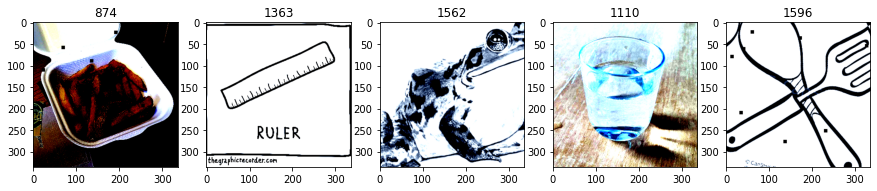

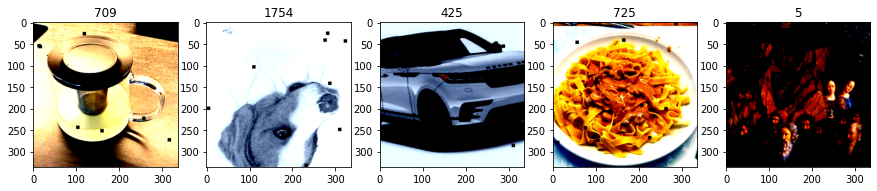

In [30]:
dataset = CLIPDataset(
    train_df['img_path'].values, 
    train_df['encoded_label'].values, 
    preprocess=preprocess, 
    transform = transforms_train
)
rcParams['figure.figsize'] = 15,5
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = i*5 + p
        item = dataset[idx]
        img, label = item['image'], item['label']
        axarr[p].imshow(img.transpose(0,1).transpose(1,2).squeeze())
        axarr[p].set_title(label.item())

In [31]:
def build_loaders(dataframe, mode):
    
    dataset = CLIPDataset(
        dataframe["img_path"].values,
        dataframe["encoded_label"].values,
        preprocess=preprocess,
        transform = transforms_train if mode == "train" else transforms_valid
    )
    
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        num_workers=WORKERS,
        shuffle=True if mode == "train" else False,
    )
    
    return dataloader

<!-- Normalize the embeddings and weights
Calculate the dot products
Calculate the angles with arccos
Add a constant factor m to the angle corresponding to the ground truth label
Turn angles back to cosines
Use cross entropy on the new cosine values to calculate loss -->

# ArcFace implementation

**ArcFace Calculation:**

* Normalize the embeddings and weights
* Calculate the dot products
* Calculate the angles with arccos
* Add a constant factor m to the angle corresponding to the ground truth label
* Turn angles back to cosines
* Use cross entropy on the new cosine values to calculate loss

In [32]:
# FIRST ATTEMPT

# class ArcFaceClassifier(nn.Module):
#     def __init__(self, emb_size, output_classes):
#         super().__init__()
#         self.W = nn.Parameter(torch.Tensor(emb_size, output_classes))
#         nn.init.kaiming_uniform_(self.W)
#     def forward(self, x):
#         # Step 1: Normalize the embeddings and weights
#         x_norm = F.normalize(x).float()
#         W_norm = F.normalize(self.W, dim=0).to(device)
#         # Step 2: Calculate the dot products
#         return x_norm @ W_norm
    
# def arcface_loss(cosine, targ, m=.4):
#     # this prevents nan when a value slightly crosses 1.0 due to numerical error
#     cosine = cosine.clip(-1+1e-7, 1-1e-7) 
#     # Step 3: Calculate the angles with arccos
#     arcosine = cosine.arccos()
#     # Step 4: Add a constant factor m to the angle corresponding to the ground truth label
#     arcosine += F.one_hot(targ, num_classes = OUTPUT_CLASSES) * m
#     # Step 5: Turn angles back to cosines
#     cosine2 = arcosine.cos()
#     # Step 6: Use cross entropy on the new cosine values to calculate loss
#     return F.cross_entropy(cosine2, targ)

# # Not using for now
# def cross_entropy(preds, targets, reduction='none'):
#     log_softmax = nn.LogSoftmax(dim=-1)
#     loss = (-targets * log_softmax(preds)).sum(1)
#     if reduction == "none":
#         return loss
#     elif reduction == "mean":
#         return loss.mean()

In [33]:
class ArcModule(nn.Module):
    def __init__(self, in_features, out_features, s = 30, m = MARGIN):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
#         nn.init.xavier_uniform_(self.weight)  # TRY
        nn.init.xavier_normal_(self.weight)

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = torch.tensor(math.cos(math.pi - m))
        self.mm = torch.tensor(math.sin(math.pi - m) * m)

    def forward(self, inputs, labels):
#         import pdb; pdb.set_trace()
        cos_th = F.linear(inputs, F.normalize(self.weight))
#         print(cos_th)
        cos_th = cos_th.clamp(-1, 1)
        sin_th = torch.sqrt(1.0 - torch.pow(cos_th, 2))
        cos_th_m = cos_th * self.cos_m - sin_th * self.sin_m
        # print(type(cos_th), type(self.th), type(cos_th_m), type(self.mm))
        cos_th_m = torch.where(cos_th > self.th, cos_th_m, cos_th - self.mm)

        cond_v = cos_th - self.th
        cond = cond_v <= 0
        cos_th_m[cond] = (cos_th - self.mm)[cond]
        
        if labels.dim() == 1:
            labels = labels.unsqueeze(-1)
        onehot = torch.zeros(cos_th.size()).cuda()
        labels = labels.type(torch.LongTensor).cuda()
        onehot.scatter_(1, labels, 1.0)
#         onehot = torch.squeeze(F.one_hot(labels, num_classes = 9)).float()
        outputs = onehot * cos_th_m + (1.0 - onehot) * cos_th
        outputs = outputs * self.s
#         print(outputs)
        return outputs

In [34]:
# class LambdaLayer(nn.Module):
#     def __init__(self, lambd):
#         super(LambdaLayer, self).__init__()
#         self.lambd = lambd
#     def forward(self, x):
#         return self.lambd(x)

In [35]:
# import torch
# from torch import nn
# x=torch.tensor([2])
# Lambda = LambdaLayer(lambda x: x )
# print(Lambda(x))

In [36]:
# FIRST ATTEMPT

# backbone(CLIP) + Dropout + Dense(units=256) + Arcface + Softmax (classes=17691)
# class MyModel(nn.Module):
#     def __init__(self, embedding_dim, output_classes):
#         super(MyModel, self).__init__()
#         self.embedding_dim = embedding_dim
#         self.output_classes = output_classes
#         self.lambd = LambdaLayer(lambda x: x)
#         self.model, self.preprocess = clip.load("ViT-L/14", device=device, jit=True) # Do I have to use just Visual model??
#         self.w_dropout = nn.Dropout(p=0.2)
#         self.w_linear1 = nn.Linear(768, self.embedding_dim, dtype=torch.float16, device = device)
#         self.w_arcfaceclassifier = ArcFaceClassifier(self.embedding_dim, self.output_classes)
#         self.w_adaptive_avg_pool = nn.AdaptiveAvgPool1d(64)
#         self.w_softmax = nn.Softmax()
        
#     def get_embs(self, x):
#         img_embeddings = self.model.encode_image(x.half())
#         l = self.w_dropout(img_embeddings)
#         l = self.w_linear1(l)
# #         l = normalize(l, dim = -1, p = 2.0)
#         return l
    
#     def forward(self, x):
#         x = self.get_embs(x)
#         x = self.w_arcfaceclassifier(x)
        
# #         x = self.softmax(x)
# #         x = normalize(x, dim = -1, p = 2.0)
        
        
# #         if self.embedding_dim != 64:
# #             x = self.adaptive_avg_pool(x)
# #         else:
# #             x = self.lambd(lambda x: x )
            
#         return x

In [37]:
class ImageEncoder(nn.Module):
    
    def __init__(self):
        super().__init__()
#         self.model, self.preprocess = clip.load("ViT-L/14", device=device, jit=True)
        self.model, self.preprocess = clip.load("ViT-L/14@336px", jit=True, device=device)
        
    def forward(self, mini_batch_images):

        img_emb = self.model.encode_image(mini_batch_images.half())

        return img_emb

In [38]:
# class GeM(nn.Module):
#     def __init__(self, p=3, eps=1e-6):
#         super(GeM, self).__init__()
#         self.p = nn.Parameter(torch.ones(1)*p)
#         self.eps = eps

#     def forward(self, x):
#         return self.gem(x, p=self.p, eps=self.eps)
        
#     def gem(self, x, p=3, eps=1e-6):
#         return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
#     def __repr__(self):
#         return self.__class__.__name__ + \
#                 '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
#                 ', ' + 'eps=' + str(self.eps) + ')'

In [39]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim=EMB_SIZE,
        output_classes=OUTPUT_CLASSES, 
        dropout=0.2
    ):
        super().__init__()
        
        self.embedding_dim = embedding_dim
        self.output_classes = output_classes
        self.clip_embedding_dim = 768
        
        self.w_dropout = nn.Dropout(p=dropout, inplace=True)
        self.w_fc1 = nn.Linear(self.clip_embedding_dim, self.embedding_dim, dtype=torch.float16, device = device) 
        self.bn1 = nn.BatchNorm1d(768)
        self.bn2 = nn.BatchNorm1d(64)
    
    def forward(self, x):
        
        features = self.bn1(x)
        features = self.w_dropout(features)
        features = self.w_fc1(features)
        features = self.bn2(features)
        features = F.normalize(features, dim = -1, p = 2.0)
        
        return features

In [40]:
class ArcFaceMargin(nn.Module):
    def __init__(
        self,
        embedding_dim=EMB_SIZE,
        output_classes=OUTPUT_CLASSES
    ):
        super().__init__()
        
        self.embedding_dim = embedding_dim
        self.output_classes = output_classes
        self.warcface_margin = ArcModule(in_features=self.embedding_dim, out_features = self.output_classes)
    
    def forward(self, features, labels):
        logits = self.warcface_margin(features.float(), labels)
        return logits

In [41]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.image_encoder = ImageEncoder()
        self.image_projection = ProjectionHead()

        self.warcface_margin = ArcFaceMargin()
        
    
    def forward(self, x, labels=None):
        
        pretrained_clip_features = self.image_encoder(x)
        features = self.image_projection(pretrained_clip_features)

        if labels is not None:
            features = self.warcface_margin(features, labels)
        
        return features


In [42]:
# class MyModel(nn.Module):
#     def __init__(self, embedding_dim, output_classes):
#         super(MyModel, self).__init__()
#         self.embedding_dim = embedding_dim
#         self.output_classes = output_classes
#         self.clip_embedding_dim = 768
#         self.image_encoder = ImageEncoder()
# #         self.model, self.preprocess = clip.load("ViT-L/14", device=device, jit=True)
# #         self.model = self.model.visual # Do I have to use just Visual model??
#         self.w_dropout = nn.Dropout(p=0.2, inplace=True)
# #         self.bn1 = nn.BatchNorm2d(self.clip_embedding_dim)
#         self.w_fc1 = nn.Linear(self.clip_embedding_dim, self.embedding_dim, dtype=torch.float16, device = device) #self.embedding_dim
# #         self.bn2 = nn.BatchNorm1d(self.embedding_dim)
#         self.warcface_margin = ArcModule(in_features=self.embedding_dim, out_features = self.output_classes)

#     def clip_embedding(self, x):
#         features = self.image_encoder(x)
#         return features
    
#     def get_embedding(self, x):
        
# #         features = self.bn1(features)
#         features = self.w_dropout(x)
# #         features = features.view(features.size(0), -1)
# #         print(features.shape)
#         features = self.w_fc1(features)
# #         features = self.bn2(features)
#         features = F.normalize(features, dim = -1, p = 2.0) # normalize(img_emb, dim = -1, p = 2.0)
#         return features
    
#     def compute_arcface(self, features, labels=None):
#         if labels is not None:
#             return self.warcface_margin(features.float(), labels)
    
#     def forward(self, x, labels=None):
        
#         clip_features = self.clip_embedding(x)
#         features = self.get_embedding(clip_features)
        
#         if labels is not None:
#             features = self.compute_arcface(features, labels)
        
#         return features


In [43]:
# model = MyModel()

In [44]:
# for params in model.parameters():
#     params.requires_grad = False

In [45]:
# for name, param in model.named_parameters():
#     if 'w_' in name or 'warcface_' in name:
#         print(name)
#         param.requires_grad = True

In [46]:
# for params in model.parameters():
#     if params.requires_grad:
#         print(params.shape)

# Training

In [47]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


In [48]:
def train_epoch(model, train_loader, optimizer, criterion):

    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    
    losses = []
    for batch in tqdm_object:
        
        batch = {k: v.to(device) for k, v in batch.items()}
        logits = model(batch['image'], batch['label'])
#         print(logits.shape)
#         print(batch['label'].max())
        loss = criterion(logits, batch['label'])
#         print(logits)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)
        
        losses.append(loss.item())
        
        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    
    loss_train = np.mean(losses)
    print(f"Epoch loss:{loss_train}")
    return loss_meter, loss_train


def valid_epoch(model, valid_loader, criterion):

    loss_meter = AvgMeter()
    
    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    
    TARGETS = []
    losses = []
    PREDS = []
    
    for batch in tqdm_object:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        logits = model(batch['image'], batch['label'].to(device).long())
        loss = criterion(logits, batch['label'].to(device).long())

        PREDS += [torch.argmax(logits, 1).detach().cpu()]
        TARGETS += [batch['label'].to(device).long().detach().cpu()]
            
        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)
        
        losses.append(loss.item())

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
        
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    accuracy = (PREDS==TARGETS).mean()
   
    loss_valid = np.mean(losses)
    
    return loss_meter, loss_valid, accuracy


def main():

    train_loader = build_loaders(train_df, mode="train")
    valid_loader = build_loaders(valid_df, mode="valid")

    model = MyModel().to(device)  
    
    for params in model.parameters():
        params.requires_grad = False
    
    for name, param in model.named_parameters():
        if 'w_' in name or 'warcface_' in name:
            param.requires_grad = True
    
    print("Trainable paramaters :")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                           lr=1e-3,betas=(0.9,0.98),
                           eps=1e-6,
                           weight_decay=0.2)

#     optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
#                            lr=1e-3, weight_decay=0.2)
    
    criterion = nn.CrossEntropyLoss()
    scheduler = CosineAnnealingLR(optimizer,T_max=EPOCH, 
                                                   eta_min=1e-5)

#     PATH = "/kaggle/input/arcface-10epochs-checkpoint-0406/best.pt" 
# #     PATH = "/kaggle/input/arcface-15moreepochs-checkpoint/best.pt" 
#     PATH = "/kaggle/working/best.pt" 
#     checkpoint = torch.load(PATH)
#     model.load_state_dict(checkpoint)
    
    best_loss = float('inf')
    for epoch in range(EPOCH):
        
        print(f"Epoch: {epoch + 1}")

        model.train()
        train_loss, train_loss_val = train_epoch(model, train_loader, optimizer, criterion)
        
        model.eval()
        with torch.no_grad():
            valid_loss, valid_loss_val, accuracy = valid_epoch(model, valid_loader, criterion)
        
        TRAIN_LOSS.append(train_loss)
        VAL_LOSS.append(valid_loss)
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            print(f"loss : {best_loss}")
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")
        
        print(f"Train Loss : {train_loss}; Validation Loss : {valid_loss}; Best Loss : {best_loss}; Val Accuracy : {accuracy}")
        scheduler.step()

In [49]:
# def train_epoch(model, train_loader, optimizer, criterion):

#     loss_meter = AvgMeter()
#     tqdm_object = tqdm(train_loader, total=len(train_loader))
    
#     losses = []
#     for batch in tqdm_object:
        
#         batch = {k: v.to(device) for k, v in batch.items()}
#         logits = model(batch['image'], batch['label'])
#         loss = criterion(logits, batch['label'])
# #         print(logits)
# #         optimizer.zero_grad()
# #         loss.backward()
# #         optimizer.step()
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
        
#         count = batch["image"].size(0)
#         loss_meter.update(loss.item(), count)
        
#         losses.append(loss.item())
        
#         tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    
#     loss_train = np.mean(losses)
#     print(f"Epoch loss:{loss_train}")
#     return loss_meter, loss_train


# def valid_epoch(model, valid_loader, criterion):

#     loss_meter = AvgMeter()
    
#     tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    
#     TARGETS = []
#     losses = []
#     PREDS = []
    
#     for batch in tqdm_object:
#         batch = {k: v.to(device) for k, v in batch.items()}
        
#         logits = model(batch['image'], batch['label'].to(device).long())
#         loss = criterion(logits, batch['label'].to(device).long())

#         PREDS += [torch.argmax(logits, 1).detach().cpu()]
#         TARGETS += [batch['label'].to(device).long().detach().cpu()]
            
#         count = batch["image"].size(0)
#         loss_meter.update(loss.item(), count)
        
#         losses.append(loss.item())

#         tqdm_object.set_postfix(valid_loss=loss_meter.avg)
        
#     PREDS = torch.cat(PREDS).cpu().numpy()
#     TARGETS = torch.cat(TARGETS).cpu().numpy()
#     accuracy = (PREDS==TARGETS).mean()
   
#     loss_valid = np.mean(losses)
    
#     return loss_meter, loss_valid, accuracy


# def main():

#     train_loader = build_loaders(train_df, mode="train")
#     valid_loader = build_loaders(valid_df, mode="valid")

#     model = MyModel(EMB_SIZE, OUTPUT_CLASSES).to(device)  
    
#     for params in model.parameters():
#         params.requires_grad = False
    
#     for name, param in model.named_parameters():
#         if 'w_' in name:
#             param.requires_grad = True
    
#     print("Trainable paramaters :")
#     for name, param in model.named_parameters():
#         if param.requires_grad:
#             print(name)

#     optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
#                            lr=1e-3,betas=(0.9,0.98),
#                            eps=1e-6,
#                            weight_decay=0.2)
    
#     criterion = nn.CrossEntropyLoss()
# #     optimizer = optim.Adam(model.parameters(), lr = 1e-3)
# #     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCH)

#     best_loss = float('inf')
#     for epoch in range(EPOCH):
        
#         print(f"Epoch: {epoch + 1}")
# #         scheduler.step()
#         model.train()
#         train_loss, train_loss_val = train_epoch(model, train_loader, optimizer, criterion)
        
#         model.eval()
#         with torch.no_grad():
#             valid_loss, valid_loss_val, accuracy = valid_epoch(model, valid_loader, criterion)
        
#         TRAIN_LOSS.append(train_loss)
#         VAL_LOSS.append(valid_loss)
        
#         if valid_loss.avg < best_loss:
#             best_loss = valid_loss.avg
#             print(f"loss : {best_loss}")
#             torch.save(model.state_dict(), "best.pt")
#             print("Saved Best Model!")
        
#         print(f"Train Loss : {train_loss}; Validation Loss : {valid_loss}; Best Loss : {best_loss}; Val Accuracy : {accuracy}")

In [ ]:
main()

Trainable paramaters :
image_projection.w_fc1.weight
image_projection.w_fc1.bias
warcface_margin.warcface_margin.weight
Epoch: 1


  0%|          | 0/199 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/BinaryOps.cpp:601.)
  # Remove the CWD from sys.path while we load stuff.
 16%|█▌        | 31/199 [08:36<44:11, 15.78s/it, lr=0.001, train_loss=26.5] 

In [ ]:
# main()

In [ ]:
# main()

In [ ]:
# main()

In [ ]:
# Image.open('../input/food-recognition-2022/raw_data/public_training_set_release_2.0/images/006316.jpg')

In [ ]:
# main()

In [ ]:
# main()

In [ ]:
# main()

In [ ]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot([float(str(i).split(": ")[-1]) for i in TRAIN_LOSS], label='Train')
ax.plot([float(str(i).split(": ")[-1]) for i in VAL_LOSS], label='Valid')

ax.set_title("Tain Vs Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.show()

# Try model on Test Set

In [ ]:
def get_image_embeddings(valid_df, model_path):

    test_loader = build_loaders(test_df, mode="test")
    
    model = MyModel().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    test_image_embeddings = []
    losses = []
    PREDS = []
    TARGETS = []
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for batch in tqdm(test_loader):
            logits = model(batch['image'], batch['label'].to(device).long())
            loss = criterion(logits, batch['label'].to(device).long())
            losses.append(loss)
            
            PREDS += [torch.argmax(logits, 1).detach().cpu()]
            TARGETS += [batch['label'].to(device).long().detach().cpu()]
        
        test_loss = np.mean(torch.tensor(losses).cpu().numpy())
        PREDS = torch.cat(PREDS).cpu().numpy()
        TARGETS = torch.cat(TARGETS).cpu().numpy()
        accuracy = (PREDS==TARGETS).mean()
#             image_embeddings = model(batch["image"].to(device)).float()
#             test_image_embeddings.append(image_embeddings)
    return model, test_loss, accuracy #torch.cat(test_image_embeddings)

In [ ]:
# model, image_embeddings = get_image_embeddings(test_df, "best.pt")
model, loss, accuracy = get_image_embeddings(test_df, "best.pt")
print(f"test loss: {loss}; test accuracy: {accuracy}")

# Model submission

In [ ]:
device

In [ ]:
model = MyModel().to(device)
model.load_state_dict(torch.load("best.pt", map_location=device))
model.eval()

In [ ]:
class FeatureEmbeddingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.clip_feature_extractor = model.image_encoder
        self.projection = model.image_projection
            
    def forward(self, x):
        x = transforms.functional.resize(x,size=[336, 336]) # resize(x,size=[224, 224])
        x = x/255.0
        x = transforms.functional.normalize(x, mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
        x = self.clip_feature_extractor(x)
        x = self.projection(x)

        return x

In [ ]:
embd_model = FeatureEmbeddingModel().to(device)
embd_model

In [ ]:
model_clip_dict = model.state_dict()
model_dict = []
for key in sorted(model_clip_dict.keys()):
    if ('image_encoder' in key) or ('w_' in key): 
        model_dict.append(key)

In [ ]:
pretrained_dict = {k: v for k, v in model_clip_dict.items() if k in model_dict}
embd_model.load_state_dict(pretrained_dict, strict=False)


In [ ]:
embd_model.eval()
saved_model = torch.jit.script(embd_model)
saved_model.save('saved_model.pt')

In [ ]:
from zipfile import ZipFile
with ZipFile('submission.zip', 'w') as zip:
    zip.write('./saved_model.pt', arcname='saved_model.pt')

# Visualize Embeddings

In [ ]:
# helper method to extract all embedings from a data loader
def get_embeddings(model, dl):
    embs = []
    ys = []
    for batch in tqdm(dl):
        with torch.no_grad():
            embs.append(model(batch['image']))
            ys.append(batch['label'])
    embs = torch.cat(embs)
    embs = embs / embs.norm(p=2,dim=1)[:,None]
    ys = torch.cat(ys)
    return embs,ys

# helper to plot embeddings in 3D
def plot_embs(embs, ys, ax):
    #ax.axis('off')
    for k in range(10):
        e = embs[ys==k].cpu()
        ax.scatter(e[:,0], e[:,1], e[:,2], s=4, alpha=.2)   


In [ ]:
model = MyModel().to(device)
model.load_state_dict(torch.load("best.pt", map_location=device))
test_loader = build_loaders(test_df, mode="test")

embs_arcface, ys_arcface  = get_embeddings(model.eval(), test_loader)

In [ ]:
_,ax1=plt.subplots(1,1, figsize=(20,10), subplot_kw={'projection':'3d'})
plot_embs(embs_arcface, ys_arcface, ax1)

plt.show()

In [ ]:
# # _,(ax1,ax2)=plt.subplots(1,2, figsize=(20,10), subplot_kw={'projection':'3d'})
# _,ax1=plt.subplots(1,1, figsize=(20,10), subplot_kw={'projection':'3d'})
# plot_embs(embs_arcface, ys_arcface, ax1)
# # plot_embs(embs_softmax, ys_softmax, ax2)

# plt.show()

# Validate with ObjectNet

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
ONET_DIR_MAP = {
    int(_dir.split("-",2)[1]):os.path.join("/kaggle/input", _dir, f'split_{_dir.split("-", 2)[1]}') \
    for _dir in os.listdir("/kaggle/input") if "objectnet" in _dir
}
ONET_CSV_MAP = {k:pd.read_csv(os.path.join(v, "onet.csv")) for k,v in ONET_DIR_MAP.items()}
for split_n, split_df in sorted(ONET_CSV_MAP.items(), key=lambda x: x[0]):
    print(f"\n\n... SPLIT #{split_n:>02} DATAFRAME (LENGTH={len(split_df)}) ...\n\n")
    display(split_df.head(3))

In [ ]:
ONET_DIR_MAP

In [ ]:
onet_df = pd.concat(list(ONET_CSV_MAP.values())).reset_index(drop=True)
onet_df

In [ ]:
onet_df["img_path"] = "/kaggle/input/objectnet-"+\
                      onet_df["split"].astype(str)+"-of-10/"\
                      "split_"+onet_df["split"].astype(str)+\
                      "/images/"+onet_df["label"]+"/"+\
                      onet_df["img_name"]

print("\n... FULL LOADED OBJECTNET DATAFRAME ...\n")
display(onet_df)

print(f"\n... OBJECTNET CLASS (N_CLASSES={onet_df.label.nunique()}) DISTRIBUTION ...\n")
for k,v in onet_df.label.value_counts().items(): print(f"\t{k:<20}\t-->\tCOUNT={v}")

In [ ]:
onet_df["img_path"] = "/kaggle/input/objectnet-"+\
                      onet_df["split"].astype(str)+"-of-10/"\
                      "split_"+onet_df["split"].astype(str)+\
                      "/images/"+onet_df["label"]+"/"+\
                      onet_df["img_name"]

print("\n... FULL LOADED OBJECTNET DATAFRAME ...\n")
display(onet_df)

print(f"\n... OBJECTNET CLASS (N_CLASSES={onet_df.label.nunique()}) DISTRIBUTION ...\n")
for k,v in onet_df.label.value_counts().items(): print(f"\t{k:<20}\t-->\tCOUNT={v}")

In [ ]:
onet_df.to_csv("full_onet.csv", index=False)
print(os.listdir("/kaggle/working"))

In [ ]:
df_onet = onet_df[['img_path', 'onet_str_label', 'int_label']]

In [ ]:
df_onet.columns = ['img_path','class','encoded_label']

In [ ]:
model = MyModel().to(device)
model.load_state_dict(torch.load("best.pt", map_location=device))
onet_loader = build_loaders(df_onet, mode="test")

# embs_arcface, ys_arcface  = get_embeddings(embd_model.eval(), onet_loader)

In [ ]:
def get_embeds(model):
    embeds = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(onet_loader):
            out = model(batch['image'].to('cuda'))
            embeds.append(out)
            labels.append(batch['label'])

    embeds = torch.cat(embeds)
    labels = torch.cat(labels)
    return (embeds, labels)

def normalize(a, eps=1e-8):
    a_n = a.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    return a_norm

# The following function first computes the cosine similarity of each of the embeddings to all other ones and then returns the top-k most similar embeddings for each entery. 
# So, it does a simple KNN and returns the indices of the closest embeddings for each of the enteries in the embeds input tensor.
def k_nearest_neighbors(embeds, k=5):
    normalized = normalize(embeds)
    preds = normalized @ normalized.T
    vals, indices = preds.sort(dim=1, descending=True)
    k += 1
    return indices[:, 1:k].long()

# I wrote this to let you analyze a model with one function call
def evaluate(model, k=5):
    embeds, labels = get_embeds(model)
    preds = k_nearest_neighbors(embeds, k=k)
    accs = (labels[preds] == labels.view(-1, 1)).float().mean(dim=1)
    return accs.mean()

# The following function first computes the cosine similarity of each of the embeddings to all other ones and then returns the top-k most similar embeddings for each entery. 
# So, it does a simple KNN and returns the indices of the closest embeddings for each of the enteries in the embeds input tensor.
def k_nearest_neighbors(embeds, k=5):
    normalized = normalize(embeds)
    preds = normalized @ normalized.T
    vals, indices = preds.sort(dim=1, descending=True)
    k += 1
    return indices[:, 1:k].long()

# I wrote this to let you analyze a model with one function call
def evaluate(model, k=5):
    embeds, labels = get_embeds(model)
    preds = k_nearest_neighbors(embeds, k=k)
    accs = (labels[preds] == labels.view(-1, 1)).float().mean(dim=1)
    return accs.mean()

In [ ]:
evaluate(model)

#0.23 -> 0.44